In [1]:
!pip install opencv-python-headless

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\visha\\anaconda3\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
!wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

ModuleNotFoundError: No module named 'google.colab'

In [6]:
import cv2

# Load YOLO model
net = cv2.dnn.readNetFromDarknet(r"C:\Users\visha\Downloads\yolov3.cfg", r"C:\Users\visha\Downloads\yolov3.weights")

# Load class names
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\darknet\darknet_io.cpp:991: error: (-213:The function/feature is not implemented) Transpose the weights (except for convolutional) is not implemented in function 'cv::dnn::darknet::ReadDarknetFromWeightsStream'


In [5]:
def detect_objects_from_frame(frame):
    height, width, _ = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)

    boxes, confidences, class_ids = [], [], []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y = int(detection[0] * width), int(detection[1] * height)
                w, h = int(detection[2] * width), int(detection[3] * height)
                x, y = center_x - w // 2, center_y - h // 2

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    return [(boxes[i], confidences[i], class_ids[i]) for i in indices.flatten()]


def draw_labels_on_frame(frame, detections):
    for (box, confidence, class_id) in detections:
        x, y, w, h = box
        color = [int(c) for c in colors[class_id]]
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        label = f"{classes[class_id]}: {confidence:.2f}"
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return frame

In [6]:
from IPython.display import display, Javascript

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');

            context.drawImage(video, 0, 0);
            stream.getTracks().forEach(t => t.stop());
            video.remove();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }

        takePhoto({quality}).then(dataUrl => {
            const a = document.createElement('a');
            a.href = dataUrl;
            a.download = 'photo.jpg';
            a.click();
        });
    ''')
    display(js)

In [7]:
take_photo()

<IPython.core.display.Javascript object>

Saving Photo on 18-10-24 at 9.33 AM.jpg to Photo on 18-10-24 at 9.33 AM.jpg


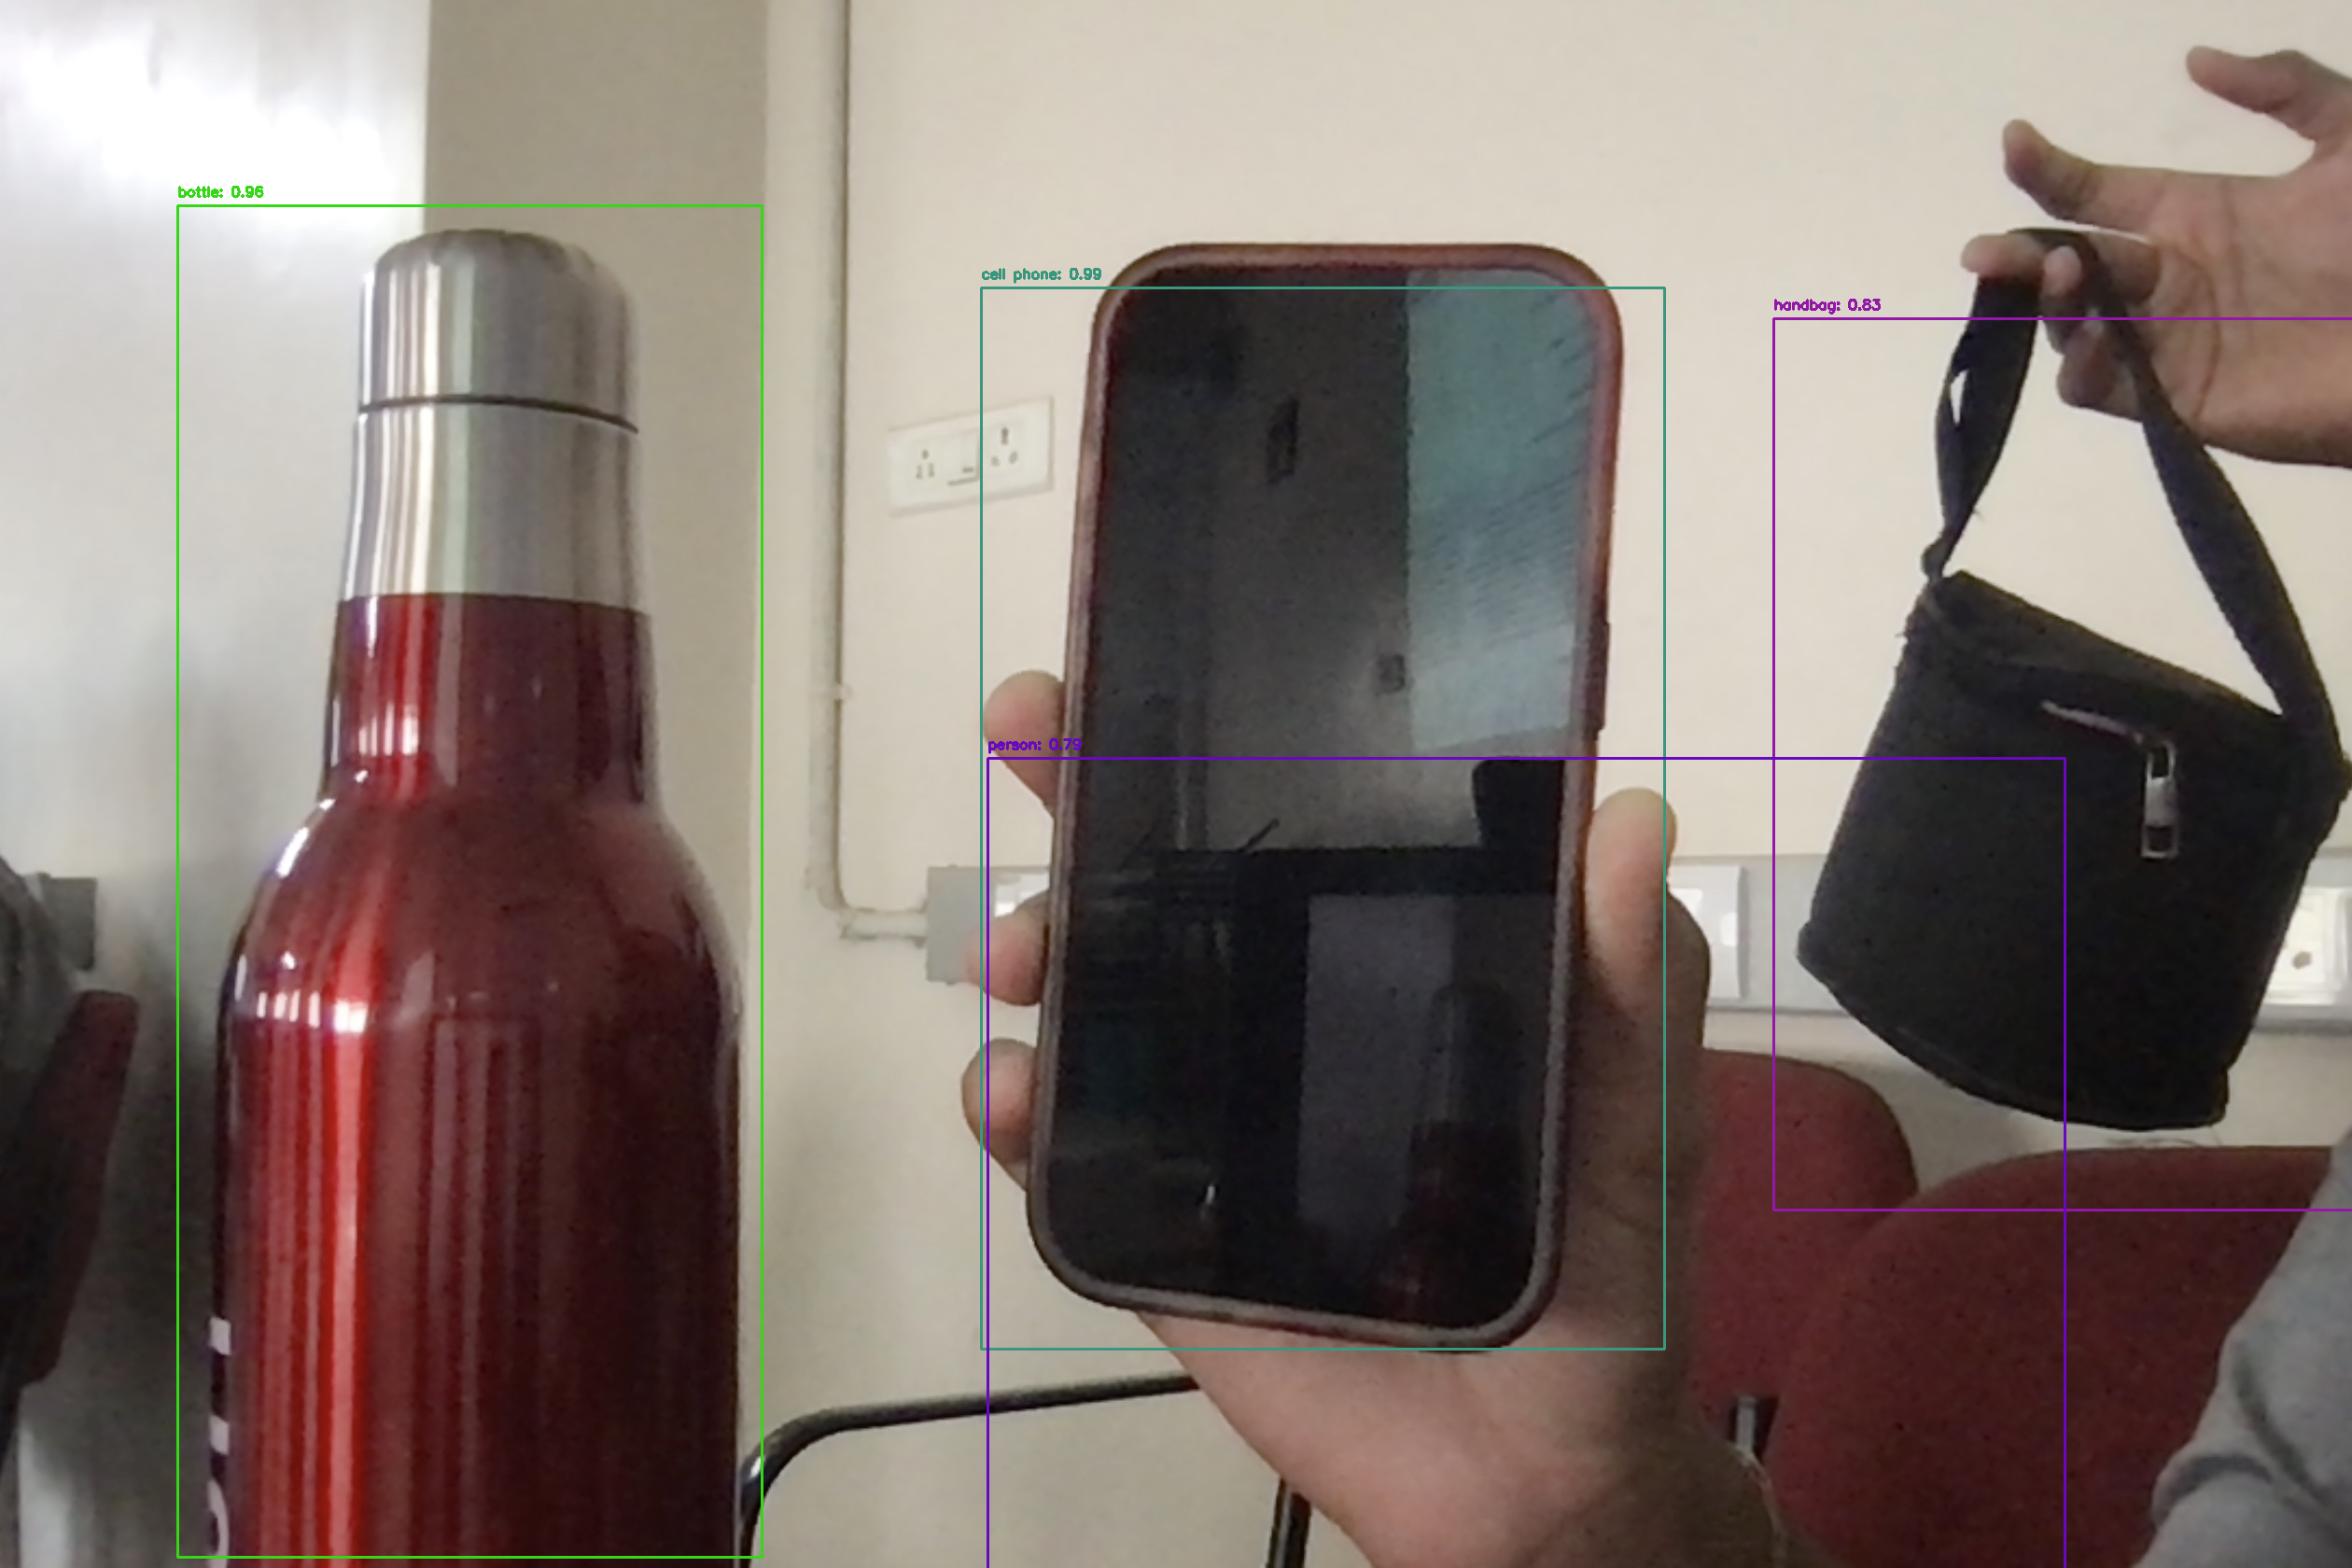

In [8]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = cv2.imread(filename)
    detections = detect_objects_from_frame(img)
    output_img = draw_labels_on_frame(img, detections)
    cv2_imshow(output_img)